<a href="https://colab.research.google.com/github/WorkaholicCat/UCS654_Assignments/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

data = pd.read_csv("data.csv", encoding='latin1')

/tmp/ipython-input-2836753786.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data.csv", encoding='latin1')


In [ ]:
x = data ['no2']
r = 102303941
a_r = 0.5 * ( r % 7)
b_r = 0.3 * ( r % 5 + 1)
z = x + a_r*np.sin(b_r*x)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
G = Generator()
D = Discriminator()

criterion = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=1e-3)
opt_D = optim.Adam(D.parameters(), lr=1e-3)

z_tensor = torch.tensor(z, dtype=torch.float32).view(-1, 1)
batch_size = 128
epochs = 3000

In [ ]:
if torch.isnan(z_tensor).any():
    z_tensor_cleaned = z_tensor[~torch.isnan(z_tensor)].view(-1, 1)
else:
    z_tensor_cleaned = z_tensor

for epoch in range(epochs):
    if len(z_tensor_cleaned) < batch_size:
        print(f"Warning: Not enough clean data points for a batch. Skipping epoch {epoch}.")
        continue

    idx = np.random.randint(0, len(z_tensor_cleaned), batch_size)
    real = z_tensor_cleaned[idx]
    noise = torch.randn(batch_size, 1)
    fake = G(noise)
    D_real = D(real)
    D_fake = D(fake.detach())
    loss_D = (
        criterion(D_real, torch.ones_like(D_real)) +
        criterion(D_fake, torch.zeros_like(D_fake))
    )
    opt_D.zero_grad()
    loss_D.backward()
    opt_D.step()
    D_fake = D(fake)
    loss_G = criterion(D_fake, torch.ones_like(D_fake))
    opt_G.zero_grad()
    loss_G.backward()
    opt_G.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch} | D Loss: {loss_D.item():.3f} | G Loss: {loss_G.item():.3f}")

Epoch 0 | D Loss: 1.523 | G Loss: 0.833
Epoch 500 | D Loss: 1.373 | G Loss: 0.743
Epoch 1000 | D Loss: 1.403 | G Loss: 0.720
Epoch 1500 | D Loss: 1.389 | G Loss: 0.690
Epoch 2000 | D Loss: 1.389 | G Loss: 0.683
Epoch 2500 | D Loss: 1.385 | G Loss: 0.654


In [ ]:
with torch.no_grad():
    z_fake = G(torch.randn(10000, 1)).numpy().flatten()


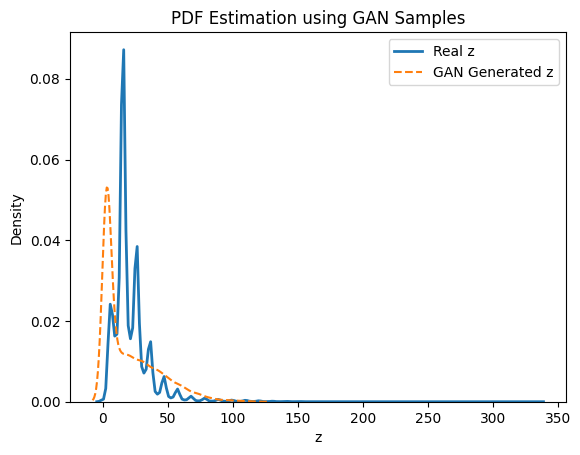

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(z, label="Real z", linewidth=2)
sns.kdeplot(z_fake, label="GAN Generated z", linestyle="--")
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()
plt.title("PDF Estimation using GAN Samples")
plt.show()